# Skipgrams on sets

In NLP, a skipgram can be defined as two tokens occurring within a fixed window of one another in a sequence. The number of skipgrams in a sequence scales linearly with the length of the sequence and the window size (ignoring edge effects at the beginning and end of the sequence). This means that each window contributes an equal number of skipgrams and the total number of windows scales like the length of the entire corpus. For example, the sequence `a, b, c, d, e` with a window size of `2` will produce the following skipgrams, 

```
a, b
a, c
b, a
b, c
b, d
c, a
c, b
c, d
c, e
d, b
d, c
d, e
e, c
e, d
```

For "gene sentences" the sequence order has no intrinsic meaning (i.e. they are sets) and so it does not make sense to define a window on these sequences to form skipgrams. In other words, the co-occurrence of two genes at opposite ends of a gene sentence is just as significant as two adjacent genes in a sentence. A natural extension would be to form skipgrams from every possible permutation of size 2 in a gene sentence. However, when we construct a co-occurrence matrix we would like sums over the rows and columns to be proportional to the rate at which unigrams appear in the corpus. 

Lets experiment with a fake corpus. 

In [1]:
from collections import Counter
import itertools
import math
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def nPr(n, r=2):
    """Number of permuations of size 2"""
    return int(math.factorial(n) / math.factorial(n - r))

In [3]:
def random_int_except(a, b, no):
    """Generate a random integer between a and b (inclusive) avoiding no"""
    x = random.randint(a, b)
    while x == no:
        x = random.randint(a, b)
    return x

In [4]:
MAX_LEN = 1000
NUM_PERMS = [0, 0] + [nPr(ii) for ii in range(2, MAX_LEN + 1)]
SAMP_MULT = 10
PERM_RATIO = {ii: (SAMP_MULT * ii) / NUM_PERMS[ii] for ii in range(2, MAX_LEN + 1)}

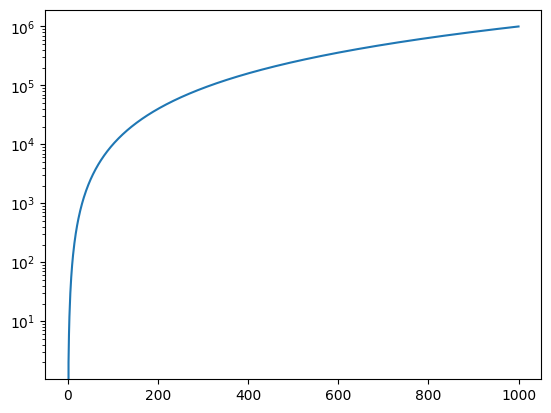

In [5]:
x = list(range(len(NUM_PERMS)))
y = NUM_PERMS
plt.plot(x, y)
plt.yscale('log')

In [6]:
def skipgrams_win(seqs, winsize=2):
    """Traditional skipgram calculation"""
    skipgram_weights = Counter()
    for seq in seqs:
        num_toks = len(seq)
        for ii in range(num_toks):
            unigram_a = seq[ii]
            # loop over offsets from ii
            for jjo in range(-winsize, winsize+1):
                jj = ii + jjo
                # skip if unigram_b will equal unigram_a
                if jjo == 0: 
                    continue
                # skip if offset is before beginning
                if jj < 0:
                    continue
                # skip if offset is after end 
                if jj >= num_toks:
                    continue
                unigram_b = seq[jj]

                skipgram = (unigram_a, unigram_b)
                skipgram_weights[skipgram] += 1 
    return skipgram_weights

In [7]:
def skipgrams_rand(seqs, kk=SAMP_MULT):
    """Choose kk random unigram_b for each unigram_a"""
    skipgram_weights = Counter()
    for seq in seqs:
        num_toks = len(seq)
        for ii in range(num_toks):
            unigram_a = seq[ii]
            for nn in range(kk):
                jj = random_int_except(0, num_toks - 1, ii)
                unigram_b = seq[jj]
                skipgram = (unigram_a, unigram_b)
                skipgram_weights[skipgram] += 1
    return skipgram_weights

In [8]:
def skipgrams_perm(seqs, do_length_norm=True):
    """Calculate every permuation of size 2. Optionally weight by length."""
    skipgram_weights = Counter()
    for seq in seqs:
        num_toks = len(seq)
        perms = list(itertools.permutations(seq, 2))
        length_norm = PERM_RATIO[num_toks]
        for unigram_a, unigram_b in perms:
            skipgram = (unigram_a, unigram_b)
            if do_length_norm:
                weight = length_norm
            else:
                weight = 1
            skipgram_weights[skipgram] += weight
    return skipgram_weights

In [25]:
def skipgrams_mix(seqs, n_max, kk=SAMP_MULT):
    """Permutations < n_max, random above n_max"""
    skipgram_weights = Counter()
    for seq in seqs:
        num_toks = len(seq)
        if num_toks <= n_max:
            perms = list(itertools.permutations(seq, 2))
            length_norm = PERM_RATIO[num_toks]
            for unigram_a, unigram_b in perms:
                skipgram = (unigram_a, unigram_b)
                weight = length_norm
                skipgram_weights[skipgram] += weight
        else:
            for ii in range(num_toks):
                unigram_a = seq[ii]
                for nn in range(kk):
                    jj = random_int_except(0, num_toks - 1, ii)
                    unigram_b = seq[jj]
                    skipgram = (unigram_a, unigram_b)
                    skipgram_weights[skipgram] += 1            
    return skipgram_weights

# Lets experiment with fake sentences

In [26]:
import string

In [27]:
# construct a corpus
# each letter can only appear once in each sequence
# seq length is random
# letter order is random
# padding with "." to remove window edge effects
winsize = 3
vocab = ["."] + list(string.ascii_lowercase)
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
min_seq_len = 4
max_seq_len = 24
num_seq = 100
corpus = []
for ii in range(num_seq):
    seq = []
    seq_len = random.randint(min_seq_len, max_seq_len)
    while len(seq) < seq_len:
        x = random.choice(vocab[1:])
        if x in seq:
            continue
        else:
            seq.append(x)
    seq = ["."] * winsize + seq + ["."] * winsize
    corpus.append(seq)

In [28]:
print(corpus[0])

['.', '.', '.', 'p', 'z', 'k', 'y', 'c', 'h', 'a', 'f', 'x', 'l', 's', 'q', 'm', 'd', 'i', 't', 'e', 'n', '.', '.', '.']


In [29]:
unigram_counts = Counter()
for seq in corpus:
    for char in seq:
        unigram_counts[char] += 1

In [30]:
x_unigram = np.zeros(len(vocab))
for u,c in unigram_counts.most_common():
    x_unigram[stoi[u]] = c

In [31]:
x_unigram

array([600.,  56.,  59.,  58.,  55.,  66.,  56.,  52.,  46.,  51.,  53.,
        53.,  51.,  59.,  51.,  58.,  46.,  53.,  50.,  55.,  48.,  49.,
        63.,  44.,  57.,  54.,  50.])

In [32]:
sw = skipgrams_win(corpus, winsize=winsize)
xw_skipgram = np.zeros((len(vocab), len(vocab)))
for (ua,ub), c in sw.most_common():
    xw_skipgram[stoi[ua], stoi[ub]] = c
    
sr = skipgrams_rand(corpus)
xr_skipgram = np.zeros((len(vocab), len(vocab)))
for (ua,ub), c in sr.most_common():
    xr_skipgram[stoi[ua], stoi[ub]] = c
    
sp = skipgrams_perm(corpus)
xp_skipgram = np.zeros((len(vocab), len(vocab)))
for (ua,ub), c in sp.most_common():
    xp_skipgram[stoi[ua], stoi[ub]] = c
    
spt = skipgrams_perm(corpus, do_length_norm=False)
xpt_skipgram = np.zeros((len(vocab), len(vocab)))
for (ua,ub), c in spt.most_common():
    xpt_skipgram[stoi[ua], stoi[ub]] = c
    
sm = skipgrams_mix(corpus, n_max=10)
xm_skipgram = np.zeros((len(vocab), len(vocab)))
for (ua,ub), c in sm.most_common():
    xm_skipgram[stoi[ua], stoi[ub]] = c

In [35]:
for u in vocab:
    xuni = x_unigram[stoi[u]]
    xw = xw_skipgram.sum(axis=0)[stoi[u]]
    xr = xr_skipgram.sum(axis=0)[stoi[u]]
    xp = xp_skipgram.sum(axis=0)[stoi[u]]
    xpt = xpt_skipgram.sum(axis=0)[stoi[u]]
    xm = xm_skipgram.sum(axis=0)[stoi[u]]
    print(f"{u}, {xw/xuni:.2f}, {xp/xuni:.2f}, {xm/xuni:.2f}, {xpt/xuni:.2f}, {xr/xuni:.2f}")

., 4.00, 10.00, 10.08, 18.93, 9.94
a, 6.00, 10.00, 10.48, 21.20, 9.88
b, 6.00, 10.00, 9.83, 21.15, 10.32
c, 6.00, 10.00, 9.50, 21.21, 9.34
d, 6.00, 10.00, 10.91, 21.51, 10.40
e, 6.00, 10.00, 10.02, 20.74, 10.67
f, 6.00, 10.00, 9.95, 21.64, 10.23
g, 6.00, 10.00, 9.50, 22.10, 10.19
h, 6.00, 10.00, 9.41, 22.20, 9.39
i, 6.00, 10.00, 10.12, 22.14, 9.29
j, 6.00, 10.00, 10.30, 21.00, 9.58
k, 6.00, 10.00, 10.23, 21.79, 9.57
l, 6.00, 10.00, 9.96, 21.67, 10.08
m, 6.00, 10.00, 9.36, 21.17, 11.25
n, 6.00, 10.00, 9.27, 22.41, 9.63
o, 6.00, 10.00, 9.48, 21.00, 10.67
p, 6.00, 10.00, 9.54, 21.80, 10.17
q, 6.00, 10.00, 9.98, 21.91, 9.47
r, 6.00, 10.00, 9.60, 21.70, 10.10
s, 6.00, 10.00, 10.04, 22.18, 10.42
t, 6.00, 10.00, 9.48, 21.75, 9.83
u, 6.00, 10.00, 9.65, 21.27, 10.22
v, 6.00, 10.00, 10.30, 21.16, 9.49
w, 6.00, 10.00, 10.86, 22.55, 9.50
x, 6.00, 10.00, 11.07, 22.04, 10.25
y, 6.00, 10.00, 10.37, 21.54, 9.98
z, 6.00, 10.00, 9.76, 21.16, 10.28
